# Introduction


Ever struggled to decide which LLM to use for a specific task? In an ideal world the most accurate model would also be the cheapest and fastest, but in practice modern agentic AI systems have to make trade-offs between accuracy, speed, and cost.

This blueprint provides a router that automates these tradeoffs by routing user prompts between different LLMs. Given a user prompt, the router:

- applies a policy (eg task classification or intent classification)
- uses a router trained for that policy to map the prompt to an appropriate LLM
- proxies the prompt to the identified fit-for-purpose LLM

For example, using a task classification policy, the following user prompts can be classified into tasks and directed to the appropriate model.

| User Prompt | Task Classification | Route To |
|---|---|---|
| "Help me write a python function to load salesforce data into my warehouse." | Code Generation | deepseek |
| "Tell me about your return policy " | Open QA | llama 70B | 
| "Rewrite the user prompt to be better for an LLM agent. User prompt: what is the best coffee recipe" | Rewrite | llama 8B |

The key features of the LLM Router are:

- OpenAI API compliant: use the LLM Router as a drop-in replacement in code regardless of which LLM framework you use.
- Flexible: use the default policy and router, or create your own policy and fine tune a router. We expect additional trained routers to be available from the community as well.
- Configurable: easily configure which backend models are available. 
- Performant: LLM Router uses Rust and NVIDIA Triton Inference Server to add minimal latency compared to routing requests directly to a model.

This notebook will walk you through deploying the router and making sample requests. We will also outline common trouble shooting steps and metrics that are available to monitor the router. The blueprint also includes an example client application, an example loadtest, and details on how to customize the router policies.

# Getting Started
>[Prerequisites](#Prerequisites)  
>[Understand the blueprint](#Understand-the-blueprint)  
>[Spin up blueprint](#Spin-up-the-blueprint)    
>[Test the LLM Router](#Test-the-LLM-Router)  
>[Use the example app](#Use-the-example-app)
>[View metrics](#View-metrics)
>[Next Steps](#Next-Steps)  
>[Shutting down blueprint](#Stopping-Services-and-Cleaning-Up)  
________________________


## Prerequisites

### Clone repository

In [ ]:
!git clone https://github.com/NVIDIA-AI-Blueprints/llm-router.git

### Install software

1. Install **[Docker](https://docs.docker.com/engine/install/ubuntu/)**

<div class="alert alert-block alert-success">
    <b>Tip:</b> Ensure the Docker Compose plugin version is 2.29.1 or higher.  Run docker compose version to confirm. Refer to Install the Compose plugin Docker documentation for more information.

2. Install **[NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html#installing-the-nvidia-container-toolkit)** to configure Docker for GPU-accelerated containers.
 If you are using a system deployed with Brev you can skip this step since Brev systems come with NVIDIA Container Toolkit preinstalled. 



<div class="alert alert-block alert-info">
    <b>Note:</b> After installing the toolkit, follow the instructions in the Configure Docker section in the NVIDIA Container Toolkit documentation.

3. Make sure necessary python packages mentioned in requirements.txt are installed 

In [ ]:
!cd llm-router && pip install -r requirements.txt

### Get API Keys

#### NVIDIA NGC Catalog key
 
The NVIDIA NGC API Key is used in this blueprint in order to pull the default router models from NGC as well as the NVIDIA Triton Inference Server docker image which is used to run those models. Refer to [Generating NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-user-guide/index.html#generating-api-key) in the NVIDIA NGC User Guide for more information.


Authenticate with the NVIDIA Container Registry with the following command:

In [ ]:
!export NGC_API_Key=$NGC_API_Key && docker login nvcr.io --username  '$oauthtoken' --password $NGC_API_Key

<div class="alert alert-block alert-info">
    <b>Note:</b> Use oauthtoken as the username and your API key as the password. The $oauthtoken username is a special name that indicates that you will authenticate with an API key and not a user name and password. After installing the toolkit, follow the instructions in the Configure Docker section in the NVIDIA Container Toolkit documentation. 

#### NVIDIA API Catalog key

The LLM router is responsible for routing requests between foundational LLM models. In this example, we will use NVIDIA NIMs. In order to access these LLMs we will use a NVIDIA API Catalog key, which is separate from the NVIDIA NGC API key used above. You can alternatively use other LLM models or even on-premise models. To do so, you would update the router configuration file which will be discussed later.

1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.

2. Select a model, such as llama3-8b-instruct.
   

3. Select an **Input** option. The following example is of a model that offers a Docker option. Not all of the models offer this option, but all include a “Get API Key” link

<img src="https://docscontent.nvidia.com/dims4/default/d6307a8/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_docker_tab.png" />

3. Click **Get API Key**.

<img src="https://docscontent.nvidia.com/dims4/default/c6e2096/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_get_api_key.png" />

4. Select **"Generate Key"**

<img src="https://docscontent.nvidia.com/dims4/default/e7c4057/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_generate_key.png" />

5. **Copy your key** and store it in a secure place. Do not share it.

<img src="https://docscontent.nvidia.com/dims4/default/4b0710a/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_copy_key.png" />

## Understand the blueprint

The LLM Router is composed of three components: 

- <b>Router Controller</b> - is a service similar to a proxy that routes OpenAI compatible requests.
- <b>Router Server</b> - is a service that classifies the user's prompt according to a routing strategy and policy. The classification is made using a pre-trained model. 
- <b>Downstream LLMs</b> - are the LLMs the prompt will be routed to, typically foundational LLMs. 

These three components are all managed in the LLM Router configuration file which is located at `src/router-controller/config.yml`. 

```yaml 
policies:
  - name: "task_router"
    url: http://router-server:8000/v2/models/task_router_ensemble/infer
    llms:
      - name: Brainstorming
        api_base: https://integrate.api.nvidia.com
        api_key: ${NVIDIA_API_KEY}
        model: meta/llama-3.1-70b-instruct
      - name: Chatbot
        api_base: https://integrate.api.nvidia.com
        api_key: ${NVIDIA_API_KEY}
        model: mistralai/mixtral-8x22b-instruct-v0.1
    ...    
  - name: "complexity_router"
    url: http://router-server:8000/v2/models/complexity_router_ensemble/infer
    llms:
      - name: Creativity
        api_base: https://integrate.api.nvidia.com
        api_key: ${NVIDIA_API_KEY}
        model: meta/llama-3.1-70b-instruct
      - name: Reasoning
        api_base: https://integrate.api.nvidia.com
        api_key: ${NVIDIA_API_KEY}
        model: nvidia/llama-3.3-nemotron-super-49b-v1
    ...
```

### Policies

The configuration file specifies the routing policies. In the default configuration, a prompt can either be classified using a `task_router` policy or a `complexity_router` policy. 

The `task_router` uses a pre-trained model that will be deployed at `http://router-server:8000/v2/models/task_router_ensemble/infer`. The model classifies prompts into categories based on the task of the prompt:
  - Brainstorming
  - Chatbot
  - Classification
  - Closed QA
  - Code Generation
  - Extraction
  - Open QA
  - Other
  - Rewrite
  - Summarization
  - Text Generation
  - Unknown

For example, the prompt `Help me write a python function to load salesforce data into my warehouse` would be classified as a `Code Generation` task.

The `complexity_router` uses a different pre-trained model that will be deployed at `http://router-server:8000/v2/models/complexity_router_ensemble/infer`. This model classifies prompts into categories based on the complexity of the prompt:
  - Creativity: Prompts that require create knowledge, eg "write me a science fiction story".
  - Reasoning: Prompts that require reasoning, eg solving a riddle.
  - Contextual-Knowledge: Prompts that require background information, eg asking for technical help with a specific product.
  - Few-Shot: Prompts that include example questions and answers.
  - Domain-Knowledge: Prompts that require broad domain knowledge, such as asking for an explanation of a historical event.
  - No-Label-Reason: Prompts that are not classified into one of the other categories.
  - Constraint: Prompts that include specific constraints, eg requesting an answer in a haiku format.

The `customize/README.md` describes how to create your own policy and classification model, providing an example showing a policy for classifying user interactions with a bank support chatbot. 

### LLMs 

The `llms` portion of the configuration file specifies where the classified prompts should be routed. For example, in the default configuration file: 

```yaml
policies:
  - name: "task_router"
    url: http://router-server:8000/v2/models/task_router_ensemble/infer
    llms:
      - name: Brainstorming
        api_base: https://integrate.api.nvidia.com
        api_key: ${NVIDIA_API_KEY}
        model: meta/llama-3.1-70b-instruct
      - name: Chatbot
        api_base: https://integrate.api.nvidia.com
        api_key: ${NVIDIA_API_KEY}
        model: mistralai/mixtral-8x22b-instruct-v0.1
```

A prompt sent to the `task_router` policy classified as a Brainstorming task would be proxied to the NVIDIA NIM `meta/llama-3.1-70b-instruct` whereas a prompt classified as a Chatbot task would be sent to `mistralai/mixtral-8x22b-instruct-v0.1`. 

### Using the router

The LLM Router is compatible with OpenAI API requests. This means that any applications or code that normally use an OpenAI API client (such as LangChain) can use LLM Router with minimal modification. For example, this RESTful API request to LLM Router follows the OpenAI specification with a few modifications:

```console
curl -X 'POST' \
  'http://0.0.0.0:8084/v1/chat/completions' \   # the URL to the deployed LLM router
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
    "model": "",                                # the model field is left blank, as the LLM router will add this based on the prompt classification
    "messages": [
      {
        "role":"user",
        "content":"Hello! How are you?"
      },
      {
        "role":"assistant",
        "content":"Hi! I am quite well, how can I help you today?"
      },
      {
        "role":"user",
        "content":"Can you write me a song? Use as many emojis as possible."
      }
    ],
    "max_tokens": 64,
    "stream": true,
    "nim-llm-router": {"policy": "task_router",
                       "routing_strategy": "triton",
                       "model": ""}
  }'
```

The primary modification is the inclusion of the `nim-llm-router` metadata in the body of the request. In most python clients this metadata would be added as `extra_body`, see `src/test_router.py` for an example. The required metadata is:

- policy: the policy to use for classification, by default either `task_router`  or `complexity_router`.
- routing_strategy: either `triton` which means the prompt is sent to a model for classification or `manual` which means that the classification is skipped - use this if the client needs to make a manual over-ride
- model: if the `routing_strategy` is `triton` leave this blank, if the routing strategy is `manual` specify the model over-ride



## Spin up the blueprint
Docker compose scripts are provided which spin up the LLM Router microservices on a single node. Make commands are provided for convenience that use the docker compose scripts.

### Download the artifacts

Start by adding your NGC API key to the commmand below and then running the `make download` command. This command will configure the NGC CLI and then download the pre-trained models for the task and complexity router policies.


In [ ]:
!export NGC_CLI_API_KEY=$NGC_API_Key && export NGC_CLI_ORG="nvidia/nemo" && cd llm-router && make download

To confirm the command ran successfully, inspect the `routers` directory. The original folder was empty, but it should now include folders for each router policy.

In [ ]:
!cd llm-router && ls ./routers

Expected output: 

```
complexity_router  complexity_router_ensemble  postprocessing_complexity_router  postprocessing_task_router  preprocessing_complexity_router  preprocessing_task_router  readme.md  task_router  task_router_ensemble
```

### Configure API Key

The LLM Router configuration now supports environment variable substitution. The configuration file at `src/router-controller/config.yaml` uses `${NVIDIA_API_KEY}` placeholders that are automatically substituted with actual API key values at runtime.

**Set your NVIDIA API key as an environment variable:**

<div class="alert alert-block alert-success">
    <b>Tip:</b> The NVIDIA API key begins with the letters nvapi-. You can obtain one from the <a href="https://developer.nvidia.com/">NVIDIA Developer Portal</a>.
</div>

**For Docker deployment:** The router controller will automatically substitute the environment variable when it starts. You can also use the legacy Python helper script for backwards compatibility.

In [ ]:
# Method 1: Set environment variable (recommended - works with both Docker and Kubernetes)
import os

# Get NVIDIA API key from environment variable (for CI compatibility)
nvapi_key = os.environ.get("NVIDIA_API_KEY")
if not nvapi_key:
    raise ValueError("NVIDIA_API_KEY environment variable not set")

# Validate the API key format
assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
os.environ["NVIDIA_API_KEY"] = nvapi_key

print(f"NVIDIA_API_KEY is set")

# Method 2: Use legacy Python script (for backwards compatibility)
# !export NVIDIA_API_KEY=$NVIDIA_API_KEY && cd llm-router && python3 src/update_config_yaml_helper.py

# Note: The router controller now supports both approaches:
# - Environment variable substitution (${NVIDIA_API_KEY} placeholders)
# - Hardcoded API keys (legacy approach)

### Start the services

Next, run the `make up` command. This command will run docker compose to start the router controller and router server. 

<div class="alert alert-block alert-success">
    <b>Note:</b> The first time you run this command the docker images needs to be pulled and built. This step could take up to 20 minutes!

In [ ]:
!cd llm-router && make up > /dev/null 2>&1

To validate the deployment of the blueprint, execute the following command to ensure the container are running.

In [ ]:
!docker ps --format "table {{{{.ID}}}}\t{{{{.Names}}}}\t{{{{.Status}}}}"

This command should produce similiar output in the following format:

If the either service fails to start or remain running you can check the service logs, for example:

In [ ]:
!cd llm-router && docker compose logs router-controller 

## Test the LLM Router

Now that the services are running, we can use Python to create prompts and pass them to the router. The following code will send the prompt to the task router policy. The classified prompt will then be forwarded to the appropriate LLM, and the response will be sent back.

<div class="alert alert-block alert-success">
    <b>Troubleshooting:</b>  If any of the steps fail there are a few options for debugging:
    <li> Start by running <code> docker compose logs router-controller </code>. This command will show the logs from the router controller microservice. The log details the steps a request takes including prompt classification and the proxied request to the LLM. </li>
    <li> The router-controller logs may indicate that the request failed to be classified, typically with an error message related to the Triton service. In this case, run <code> docker compose logs router-server </code>. You may need to try re-downloading the router models, or double checking that the GPU hardware requirements for the router server are satisfied. </li> 
    <li> The router-controller logs may indicate that the request was correctly classified, but then failed during the proxied LLM call. Typical indications would be a 403, 404, or 500 error message. In this case, double check that the router controller configuration file has appropriate URLs for the LLM including a valid api key and valid model names. If you encounter a 500 error message, re-trying the code may be sufficient. </li> 
</div>

In [ ]:
from openai import OpenAI
import os
from typing import Literal 

def make_request_to_router(PROMPT: str, policy: Literal['task_router', 'complexity_router']): 
    """ make a request to a LLM through the LLM router """
    
    client = OpenAI(
        api_key="open-ai-placeholder", # can leave this place holder as-is, the API key for the proxied LLM is pulled from the router configuration file
        max_retries=20,
        base_url="http://127.0.0.1:8084/v1/" # the url for the router-controller running locally
    )

    messages=[
        {
            "role":"user",
            "content": PROMPT
        }
    ]

    extra_body = {
        "nim-llm-router": {
            "policy": policy,     
            "routing_strategy": "triton", 
        }
    }

    try:
        chat_completion = client.chat.completions.with_raw_response.create(
        messages=messages,
        model="",
        extra_body=extra_body
        )
    except Exception as e:
        print("\nError Response:")
        if hasattr(e, 'response'):
            print(f"Status Code: {e.response.status_code}")
            print(f"Error Message: {e.response.text}")
        else:
            print(f"Error: {str(e)}")
    
    chosen_classifier = chat_completion.headers.get('X-Chosen-Classifier')

    completion = chat_completion.parse()
    
    return completion, chosen_classifier

PROMPT = "Write a python function that implements the two sum algorithm."
chat_completion, chosen_classifier = make_request_to_router(PROMPT, "task_router")

print(f"Prompt was classified as {chosen_classifier} & handled by model: {chat_completion.model}")
print(chat_completion.choices[0].message.content)

The example above requested code generation and was classified accordingly, being routed to a the configured code generation LLM. A simpler rewrite prompt is classified and routed to accordingly. For example:

In [ ]:
PROMPT = "Rewrite this prompt to be better suited for a LLM. Prompt: Tell me about polar bears"
chat_completion, chosen_classifier = make_request_to_router(PROMPT, "task_router")

print(f"Prompt was classified as {chosen_classifier} & handled by model: {chat_completion.model}")
print(chat_completion.choices[0].message.content)

You can also make requests to the router directly through a curl request. For an example look at `src/test_router.sh`.

### Understanding classifications 

Invoking the router leads to a two step process:

1. The user's prompt is classified based on the router controller policy

2. Based on the classification, the request is forwarded to the downstream LLM

By default, the router proxies back a response that is identical to an OpenAI API. If you want to see details of the router's classification system you can bypass the proxy and directly interact with the router policy model. The code below shows how a prompt would be classified with the task router policy.

*Note*: You can also see how a prompt is routed by viewing the router logs during a request. Run `docker compose logs router-controller -f` while making a request to see the details. You can also inspect the headers from the request to see information about the prompt classification if you use a client that returns the header values. Finally, aggregate metrics about prompt classification and routing are visible through a metrics service as described in the [Metrics](#view-metrics) section.

In [ ]:
import numpy as np
import tritonclient.http as httpclient
from transformers import AutoConfig
import warnings
import yaml
import os
warnings.filterwarnings('ignore')

# Get NVIDIA API key from environment variable (for CI compatibility)
nvapi_key = os.environ.get("NVIDIA_API_KEY")
if not nvapi_key:
    raise ValueError("NVIDIA_API_KEY environment variable not set")

PROMPT = "Can you write me a song?  Use as many emojis as possible."

def send_request(triton_client, text):
    input_text = np.array([[text]], dtype=object)
    inputs = [httpclient.InferInput("INPUT", input_text.shape, "BYTES")]
    inputs[0].set_data_from_numpy(input_text)

    outputs = [httpclient.InferRequestedOutput("OUTPUT")]

    response = triton_client.infer(model_name="task_router_ensemble", inputs=inputs, outputs=outputs)
    return response

# Load the config
config = AutoConfig.from_pretrained("nvidia/prompt-task-and-complexity-classifier")

# Load router configuration (note: this shows the template format with environment variable placeholders)
with open("llm-router/src/router-controller/config.yaml", 'r') as file:
    router_config = yaml.safe_load(file) 

print("Note: The configuration file uses ${NVIDIA_API_KEY} placeholders.")
print("The router controller automatically substitutes these with actual API keys at runtime.")
print(f"Current NVIDIA_API_KEY environment variable: {'Set' if nvapi_key else 'Not set'}")
print() 

models = [llm['model'] for llm in router_config['policies'][0]['llms']]

# Make the request
triton_client = httpclient.InferenceServerClient(url="127.0.0.1:8000")
result = send_request(triton_client, PROMPT)

# Format the output
output_data = result.as_numpy("OUTPUT")
predicted_task_index = np.argmax(output_data)

task_types = list(config.task_type_map.values())
predicted_task = task_types[predicted_task_index]
predicted_model = models[predicted_task_index]

print(f"Using policy: task_router")
print(f"Input prompt: {PROMPT}")
print(f"Predicted class: {predicted_task}")
print(f"Predicted model: {predicted_model}")

### Use a different policy

The first test used the task router policy. You can also send requests that use the complexity router policy.

In [ ]:
from openai import OpenAI
import os

PROMPT = "Can you write me a song?  Use as many emojis as possible."

# The following prompts showcase complexity routing, uncomment as desired

## Reasoning
# PROMPT = """
# A farmer needs to transport a wolf, a goat, and a cabbage across a river. 
# He has a boat that can only carry himself and one item at a time. 
# If left alone together, the wolf will eat the goat, and the goat will eat the cabbage. 
# How can the farmer safely transport all three items across the river?
# """

## Domain Knowledge 
# PROMPT = """
# Re-solve the classic farmer transporting a wolf, goat, and cabbage riddle using graph theory. 
# Define nodes as valid states (e.g., 'FWGC-left') and edges as permissible boat movements. Formalize the solution as a shortest-path algorithm.
# """

## Creativity
# PROMPT = """
# Write a scientific fiction story about the classic farmer transporting a wolf, goat, and cabbage riddle"
# """

chat_completion, chosen_classifier = make_request_to_router(PROMPT, "complexity_router")

print(f"Prompt was classified as {chosen_classifier} & handled by model: {chat_completion.model}")
print(chat_completion.choices[0].message.content)

## Use the example app

## Environment Setup

**Important**: The LLM Router now supports environment variable substitution for API keys. The router controller automatically substitutes `${NVIDIA_API_KEY}` placeholders in the configuration file with actual API key values at runtime.

To use the router controller with NVIDIA's LLM APIs, you need to set your NVIDIA API key as an environment variable:

```bash
# Set your NVIDIA API key (replace with your actual key)
export NVIDIA_API_KEY="your_actual_api_key_here"
```

You can obtain an API key from the [NVIDIA Developer Portal](https://developer.nvidia.com/).

**Note**: The example application itself doesn't require the API key - only the router controller needs it for routing decisions and LLM API calls.


The blueprint also includes an example client application that is useful for testing different prompts and routing policies.

In [ ]:
# Start the example application (does not require API key for the app itself)
!cd llm-router && make app > /dev/null 2>&1

> If deploying this on a brev launchable, go back to your instance page and open the app from the ports page

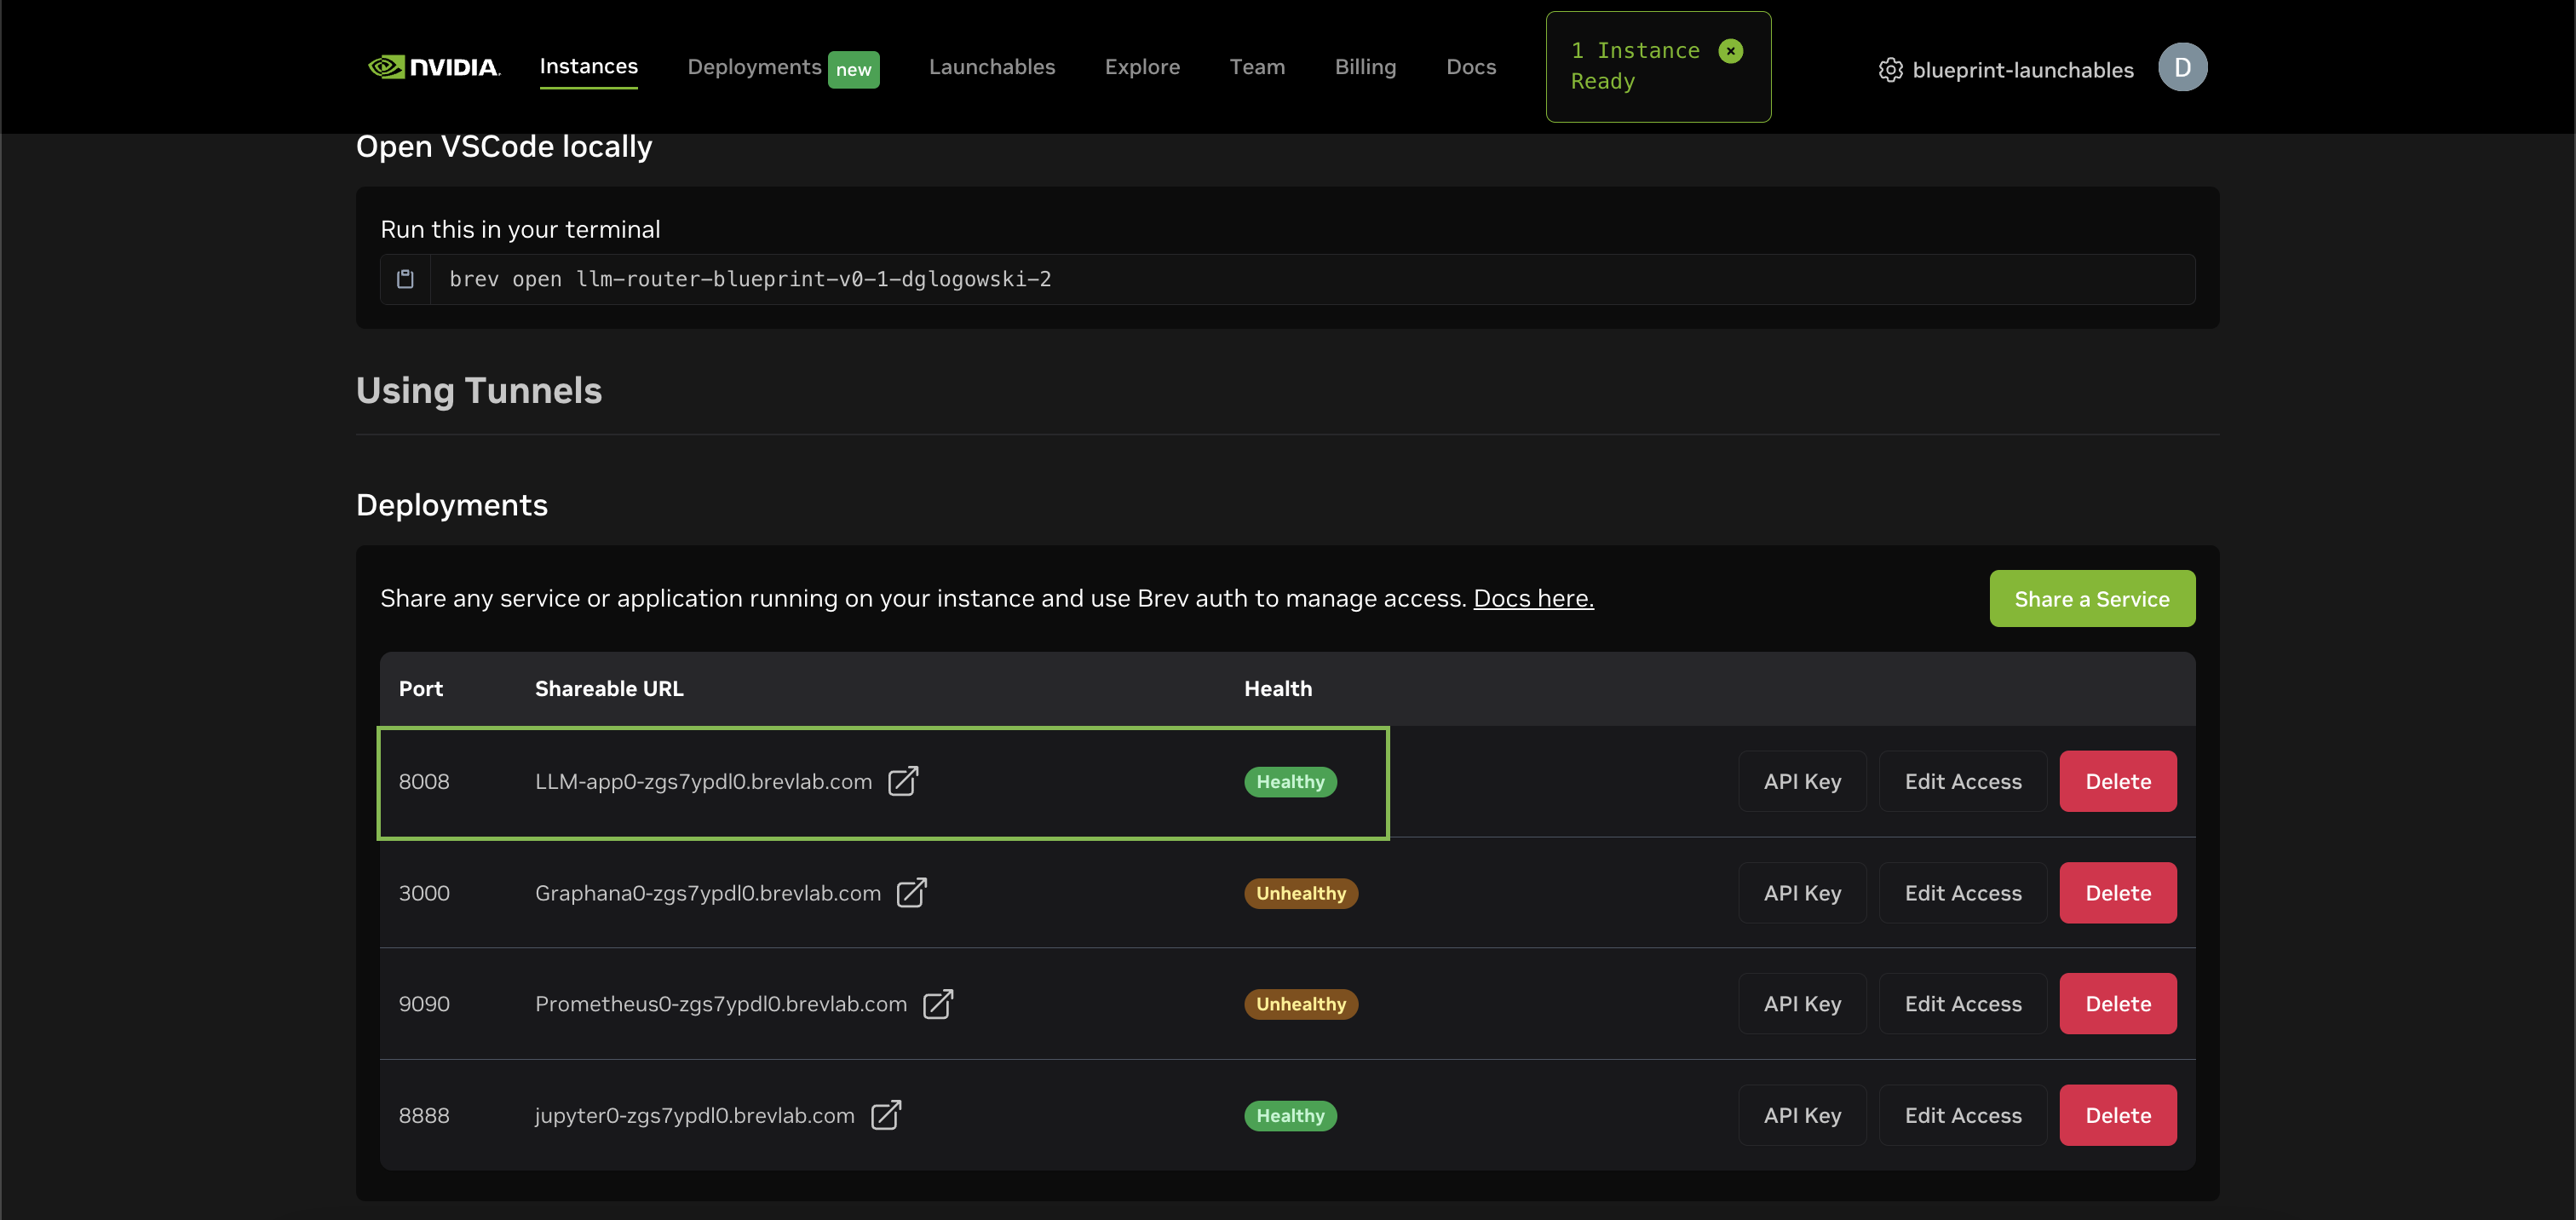

> When deploying locally, the app will be accessible at `http://localhost:8008`. 

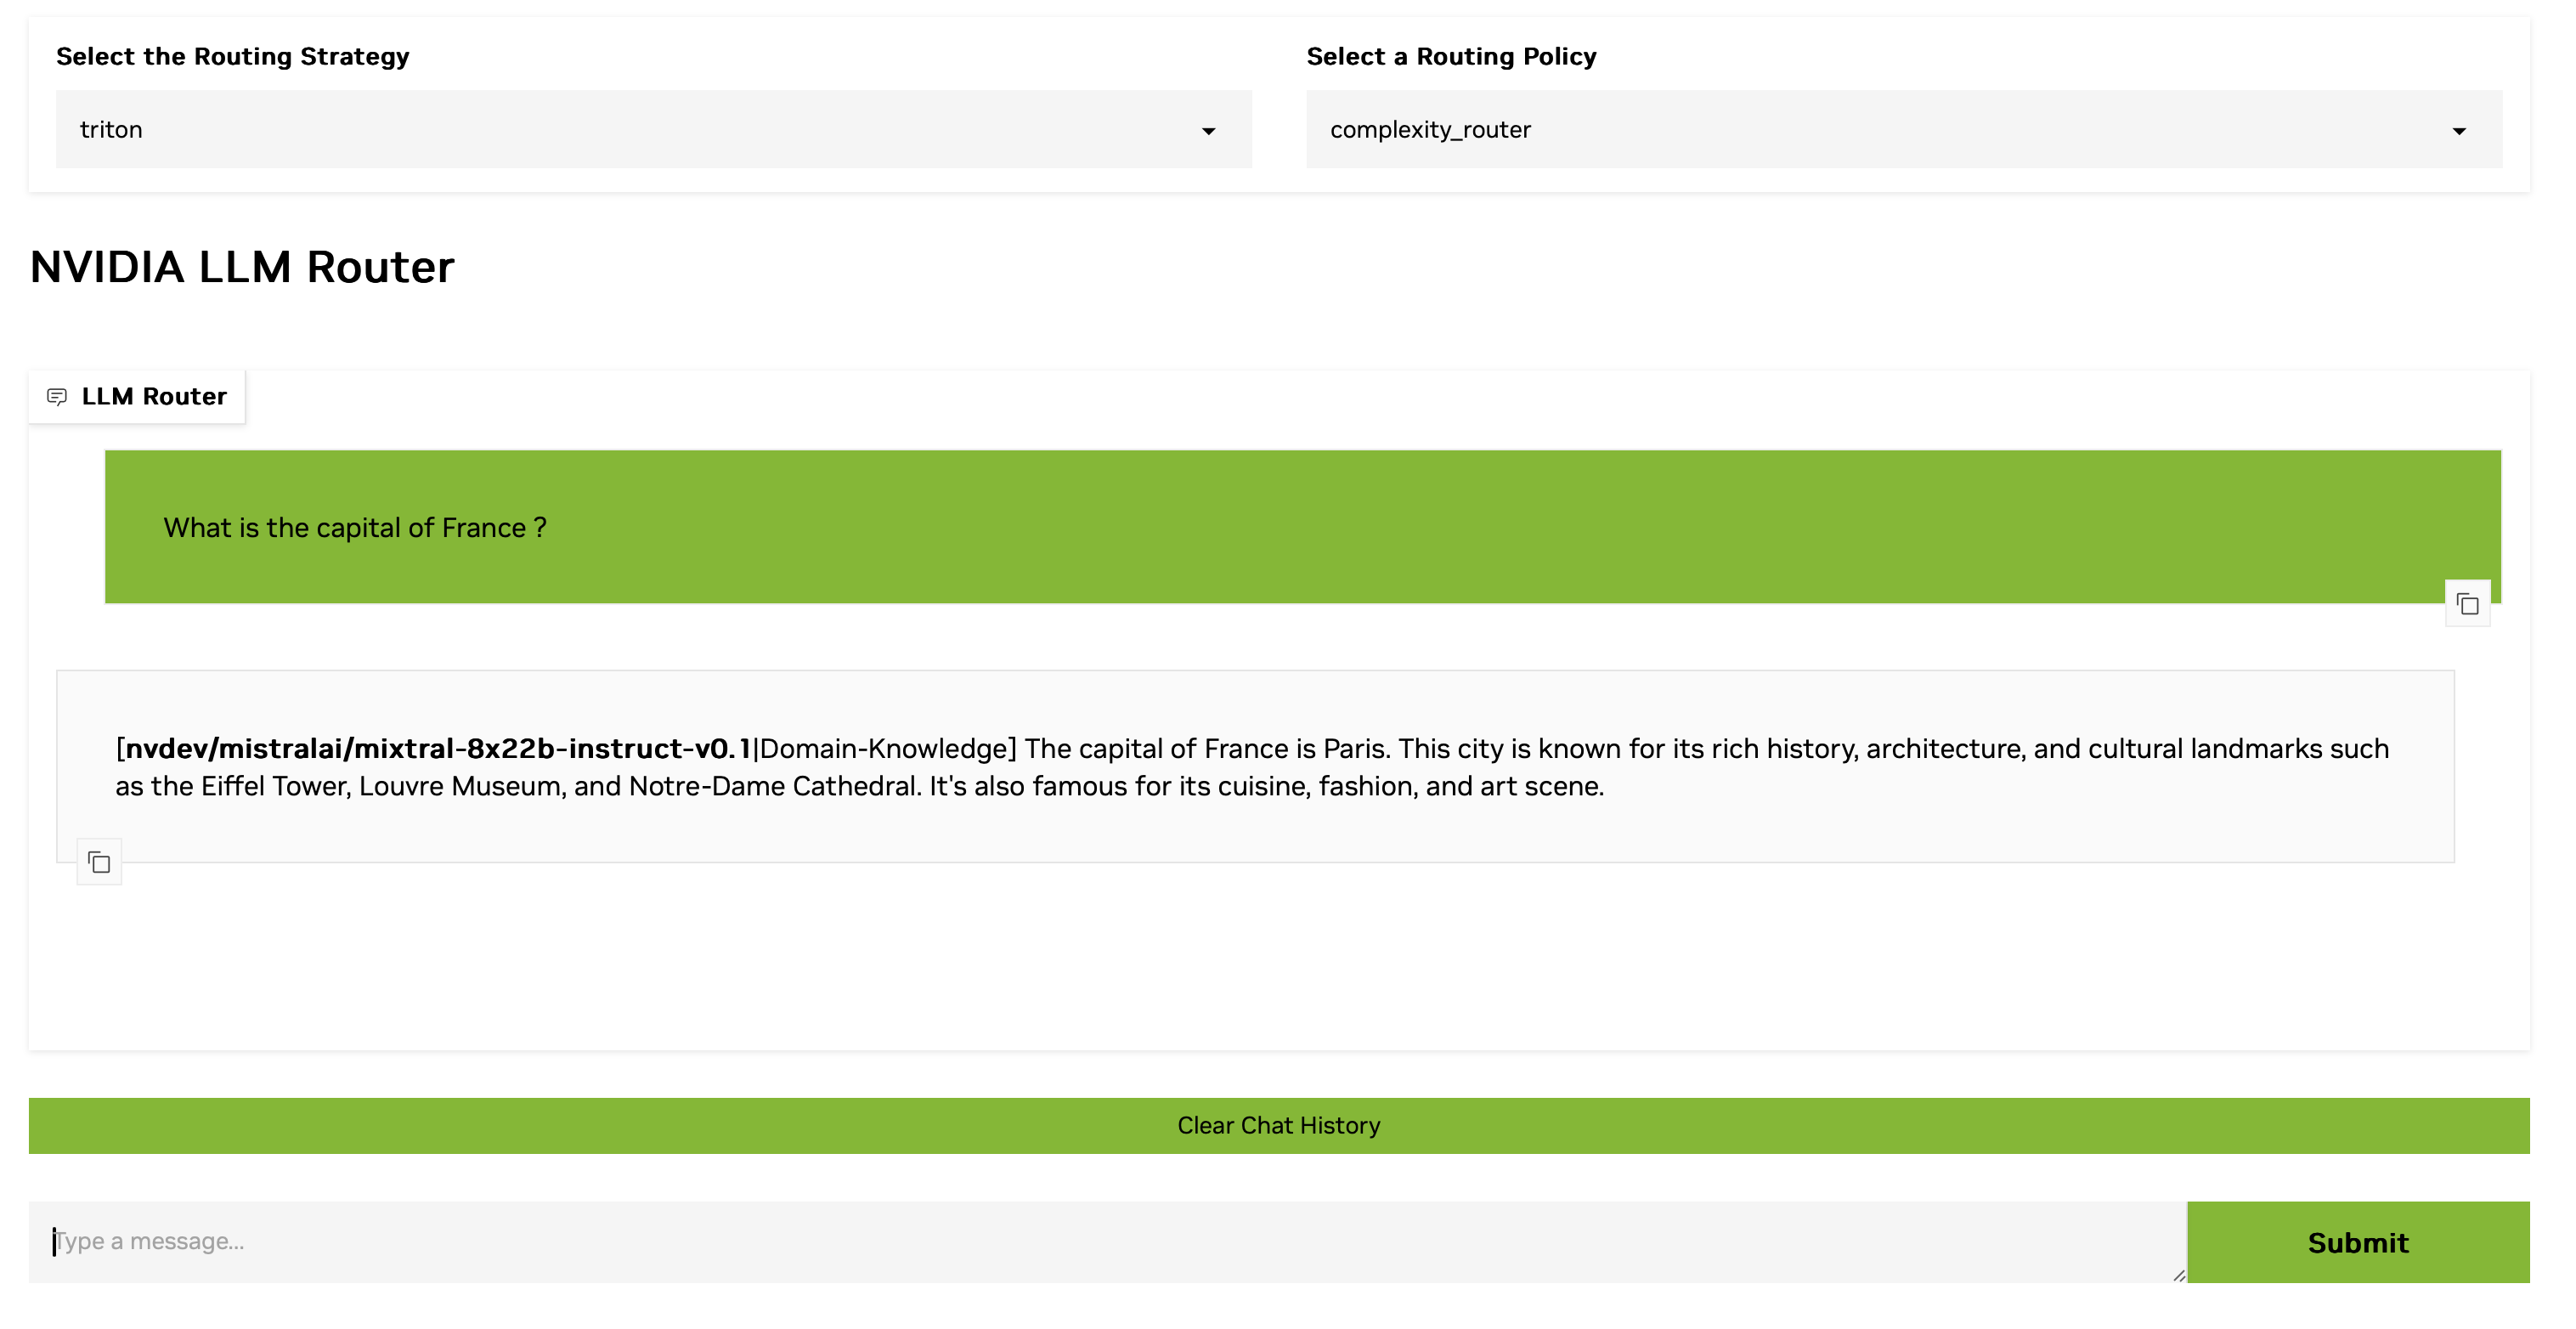

## View metrics

The LLM Router automatically emits metrics to help you track behavior. To see these metrics, run the commeand below. This make command will launch Prometheus and Grafana. 


In [ ]:
!cd llm-router && make metrics > /dev/null 2>&1

- Open Grafana by navigating to `http://localhost:3000`
- Login using the default credentials, username: `admin` and passwords: `secret`. 
- Select "Data source" and pick "Prometheus". Enter `http://prometheus:9090` as the Prometheus URL.
- Use the Grafana "Explore" query interfaces to look at available metrics.

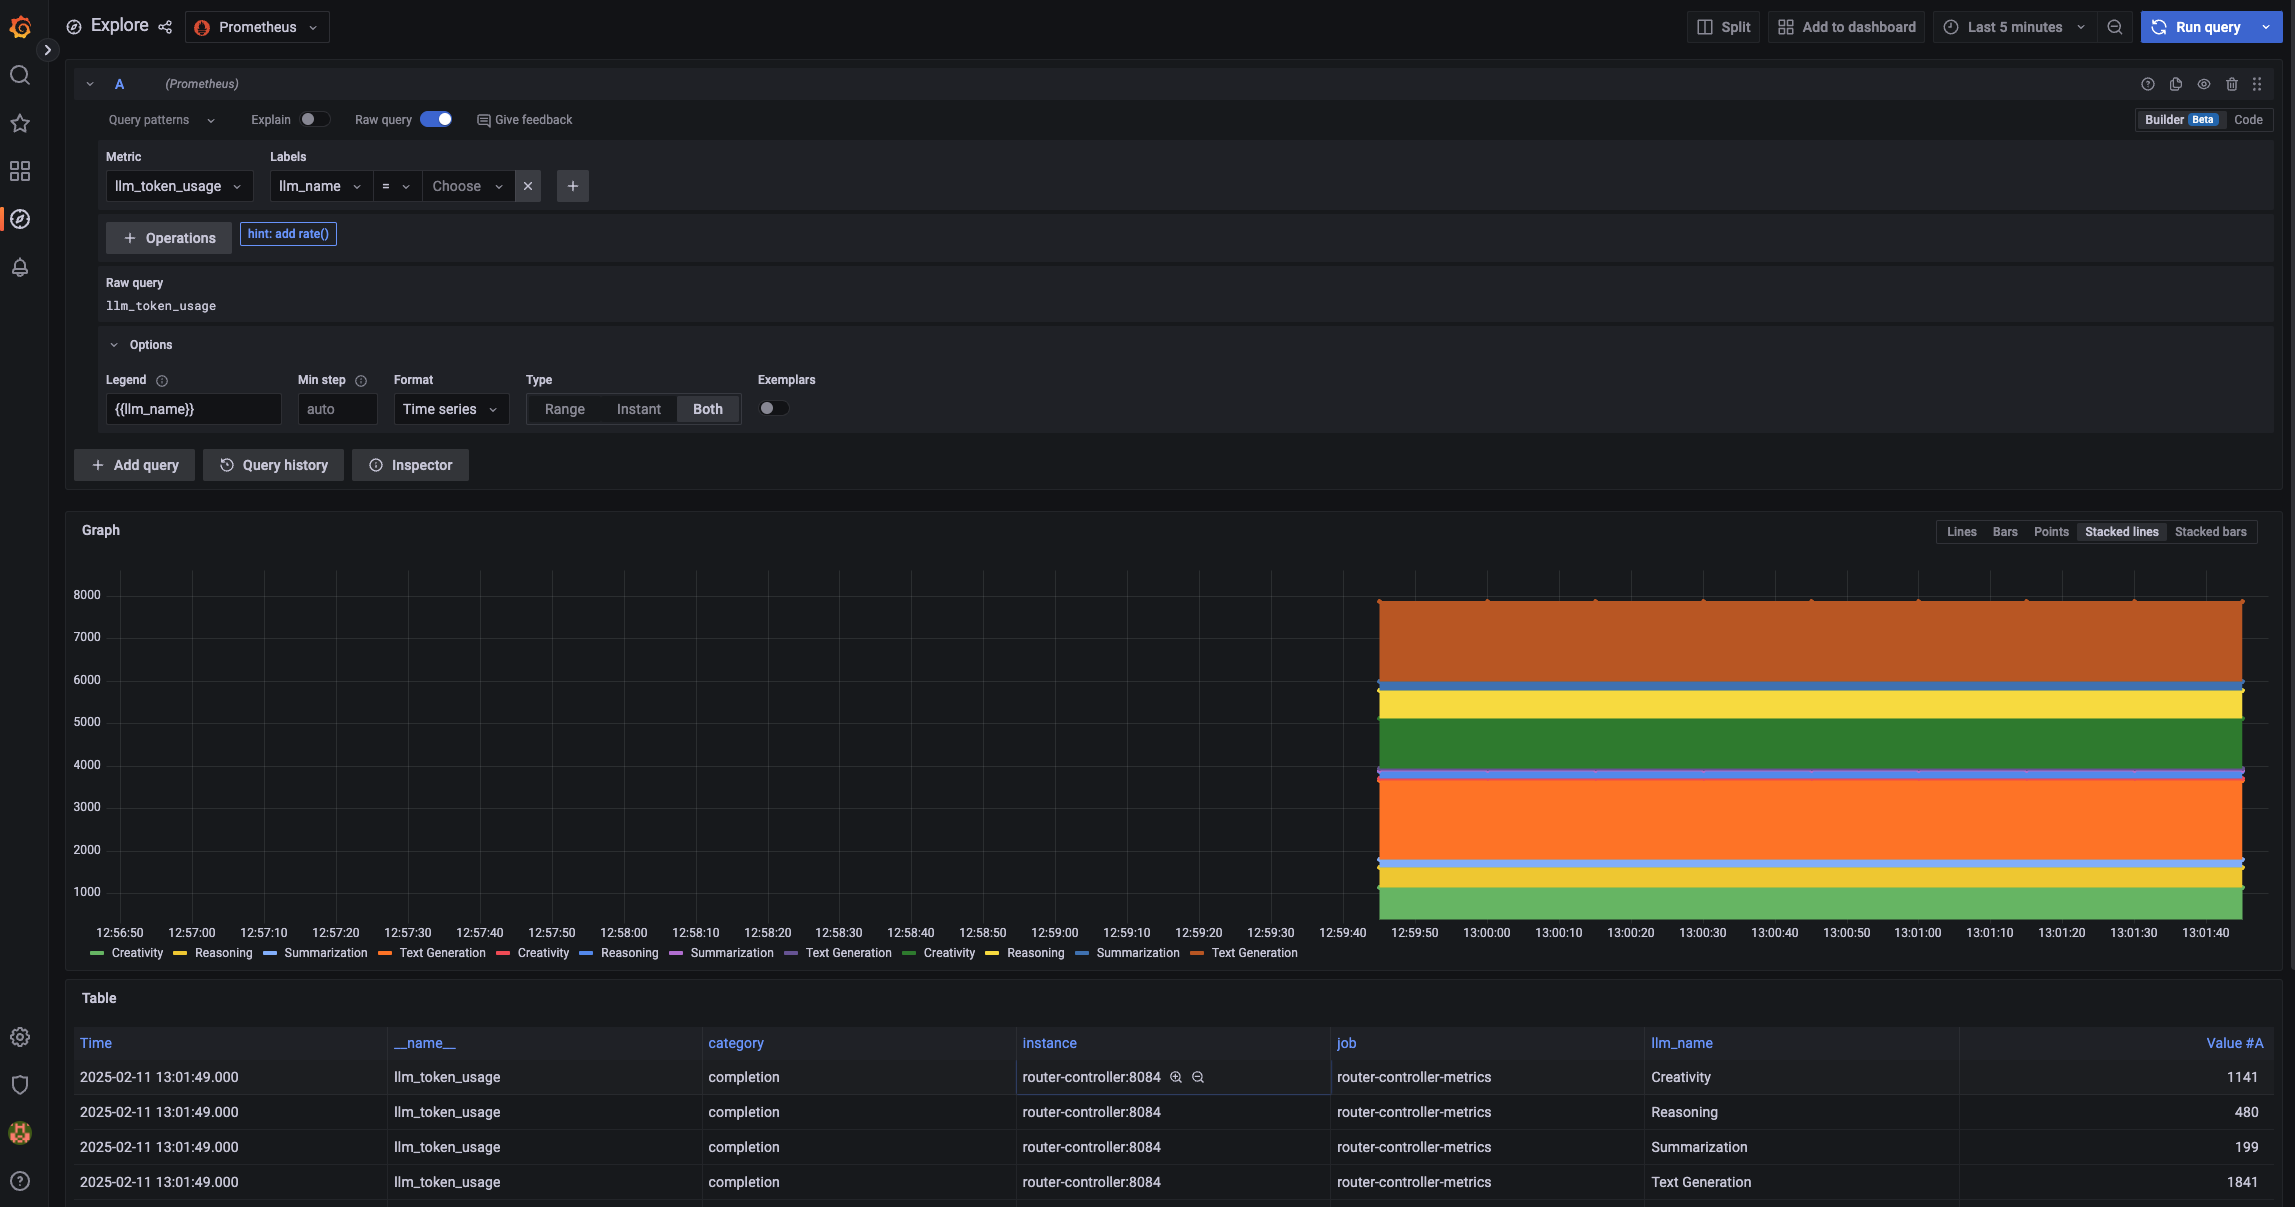

## Kubernetes Deployment Alternative

For production deployments, you can also deploy the LLM Router on Kubernetes using the provided Helm chart:

```bash
# Set your API key as environment variable
export NVIDIA_API_KEY=\"your_api_key_here\"

# Deploy using Helm
helm install llm-router ./deploy/helm/llm-router -f deploy/helm/llm-router/values.override.yaml
```

The Kubernetes deployment includes:
- High availability with multiple replicas
- Resource management and limits  
- Health checks and monitoring
- Automatic environment variable substitution for API keys

For detailed Kubernetes deployment instructions, see `deploy/helm/llm-router/README.md`.\n\n---\n\n**The rest of this notebook demonstrates the Docker deployment approach:**


## Next Steps

The LLM Router is running and you know how to adapt your OpenAI API code to use it. Further explore:

- Customization: The LLM Router directs requests to backend models based on the config file `src/router-controller/config.yml`. Update the model endpoints in this file to change the backend routing behaviors. You may also wish to customize the router, see `customize/README.md` for details.

- Performance: This blueprint includes a sample load test that can be run against the router. Metrics are automatically created and stored in a Grafana dashboard. To get started, run `make loadtest`. 

## Stopping Services and Cleaning Up

To shut down the microservices, run the following command

In [ ]:
!cd llm-router && make down